In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (18.0, 12.0)

%matplotlib inline

In [2]:
df = pd.read_csv("./facebook_combined.txt.gz", compression='infer', sep=" ")
#df = pd.read_csv("./twitter_combined.txt.gz", compression='infer', sep=" ", header=None)

print(len(df))
df.head()

88233


,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [3]:
df.columns = ["0", "1"]

In [4]:
nodes = list(set(df["0"]) | set(df["1"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"0": df["0"].apply(lambda x: nodes_to_idx[x]), 
                   "1": df["1"].apply(lambda x: nodes_to_idx[x])})
df.head()          

,0,1
0,0,2
1,0,3
2,0,4
3,0,5
4,0,6


In [5]:
df.describe()

,0,1
count,88233.000000,88233.000000
mean,1864.802908,2154.223533
std,910.275802,893.685198
min,0.000000,2.000000
25%,1160.000000,1600.000000
50%,1983.000000,2259.000000
75%,2423.000000,2631.000000
max,4031.000000,4038.000000


In [6]:
e = len(df)
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

88233 4039


## Passage au Laplacien

In [7]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = 1.0 * ((facebook2 + facebook2.T) !=0)

In [8]:
(facebook2 > 1)

<4039x4039 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [9]:
%time deg = np.array(facebook2.sum(axis=0))[0]

print(deg.shape)
print((deg == 0).sum())

Wall time: 1 ms
(4039,)
0


In [10]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L = L.astype(np.float32)
L

<4039x4039 sparse matrix of type '<class 'numpy.float32'>'
	with 180505 stored elements in Compressed Sparse Row format>

In [11]:
from scipy.sparse.linalg import eigsh

In [12]:
import os.path
import pickle

n_clusters = int(L.shape[0]/40) 
neig = 2 + int(np.log2(n_clusters))

print(n_clusters, neig)

f_vec = "pkl/twitter_eigen_vec_%d.pkl" % neig
f_val = "pkl/twitter_eigen_val_%d.pkl" % neig

if os.path.isfile(f_vec) and os.path.isfile(f_val):
    
    with open(f_vec, "rb") as f:
        eigvec = pickle.load(f)
    with open(f_val, "rb") as f:
        eigval = pickle.load(f)
    
else:
    %time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
    with open("pkl/twitter_eigen_vec.pkl", "wb") as f:
        pickle.dump(eigvec, f)
    with open("pkl/twitter_eigen_val.pkl", "wb") as f:
        pickle.dump(eigval, f)
# 15 min for 14 et 20...
# 21 min for 12

#%time eigval, eigvec = eigsh(L, neig, which='LM', tol=1e-2, sigma=0)
# very very long! => SystemError: gstrf was called with invalid arguments

eigval

100 8
Wall time: 673 ms


array([ -1.40091706e-05,   1.81676168e-02,   2.89877504e-02,
         4.71886210e-02,   6.83572814e-02,   1.10637046e-01,
         1.63130969e-01,   6.78481758e-01], dtype=float32)

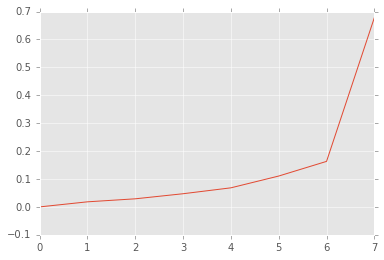

In [13]:
plt.plot(eigval)

In [14]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

3285 754


(2, 4039)


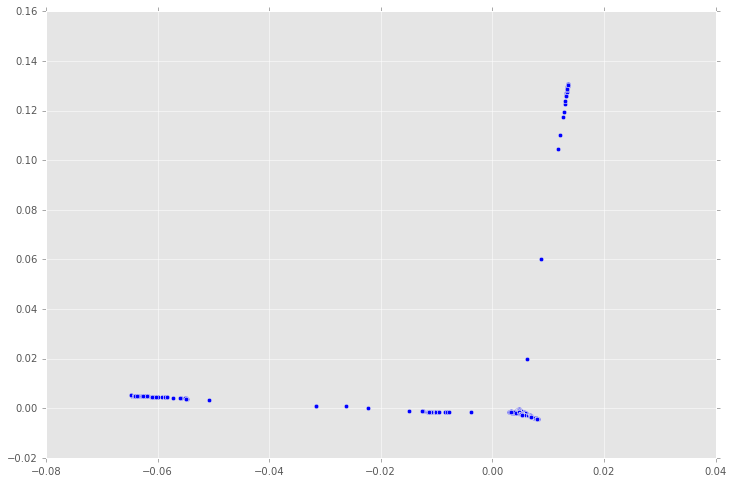

In [15]:
proj = eigvec[:, 1:3].T
print(proj.shape)

pylab.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(proj[0], proj[1])

## kmeans clustering

(4039, 2)
Wall time: 38 ms
4
[[ 0.00568228  0.01334973 -0.06274241 -0.01140638]
 [-0.00239223  0.12797256  0.00487817 -0.00150872]]


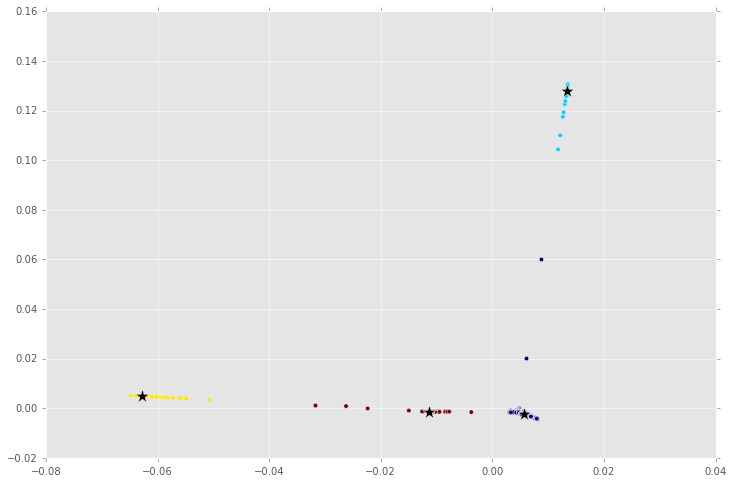

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

n_clusters = 4

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
# clf = DBSCAN(eps = 0.005)

print(proj.T.shape)

%time clusters = clf.fit_predict(proj.T)

print(len(np.unique(clusters)))

plt.scatter(proj[0], proj[1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

### Clustering plus poussé
**Attention:** ici nous normalisons les vecteurs propres.
Cela fait deux différences avec l'algorithme standard de spectral clustering
- normalisation vecteurs propres vs pas normalisation => je retire la normalisation
- 2^k-means sur k vecteurs propres contre k-means sur k vecteurs => je diminue le nombre de clusters

In [17]:
print(eigvec.min(axis=0), eigvec.max(axis=0), eigvec.mean(axis=0))
print(1/(eigvec.max(axis=0) - eigvec.min(axis=0)))

[ 0.01572021 -0.06474862 -0.00433451 -0.03774124 -0.03587607 -0.03761902
 -0.03010773 -0.03772732] [ 0.01574618  0.01353983  0.13069075  0.02744657  0.02286007  0.02638814
  0.02098183  0.15322307] [  1.57349855e-02  -1.38942721e-06   1.18689832e-06   2.70565829e-06
  -1.94170366e-06  -2.94319136e-07   3.36135372e-06   2.71533906e-08]
[  3.84964102e+04   1.27732763e+01   7.40602160e+00   1.53402910e+01
   1.70252914e+01   1.56232510e+01   1.95734730e+01   5.23696232e+00]


In [18]:
eigvec_n = (eigvec-eigvec.min(axis=0)) / (eigvec.max(axis=0) - eigvec.min(axis=0))
print(eigvec_n.shape, eigvec.shape)
print(eigvec_n.mean(axis=0))

(4039, 8) (4039, 8)
[ 0.56892288  0.82703429  0.03211026  0.57900316  0.61076754  0.58772689
  0.5893786   0.19757667]


n_clusters = 40
(4039, 7)
Wall time: 2.87 s
40


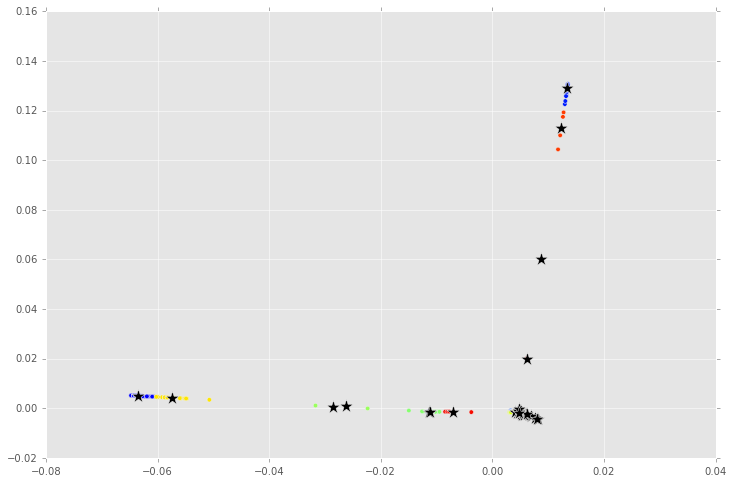

In [19]:
#n_clusters = int(v/40)
n_clusters = int(v/100)
print("n_clusters = %d" % n_clusters)

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, n_jobs=4)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
#clf = DBSCAN(eps = 0.0005)

#X = eigvec_n[:,1:]
X = eigvec[:,1:]

print(X.shape)
%time clusters = clf.fit_predict(X)
print(len(np.unique(clusters)))

plt.scatter(X[:,0], X[:,1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    # print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

## display clustered graphs

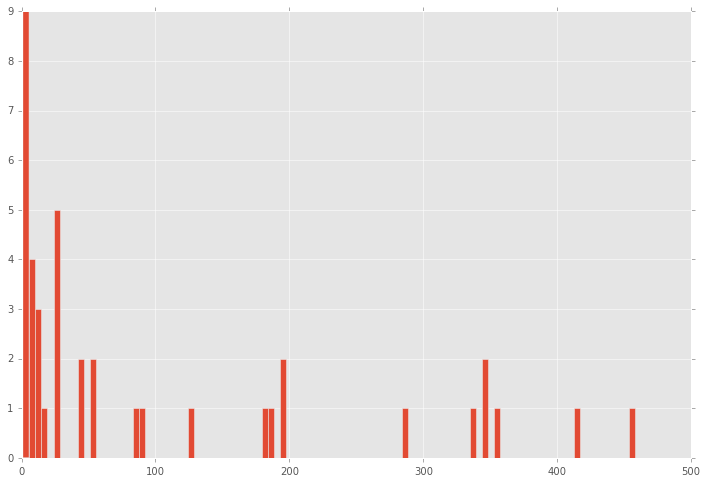

In [20]:
vc = pd.Series(clusters).value_counts()
vc.hist(bins=100)

In [21]:
pd.DataFrame({'cnt': vc}).groupby(["cnt"]).size()

cnt
1      4
2      1
3      2
4      2
8      2
10     2
11     2
13     1
16     1
25     2
26     1
27     1
28     1
43     1
44     1
54     1
55     1
84     1
91     1
127    1
180    1
187    1
193    1
197    1
288    1
338    1
347    1
348    1
354    1
413    1
458    1
dtype: int64

In [22]:
import networkx as nx

%time g = nx.Graph(list(df.to_records(index=False)))
g

Wall time: 1.1 s


Cluster #5 is of size 180
pseudo-degree of cluster is 5


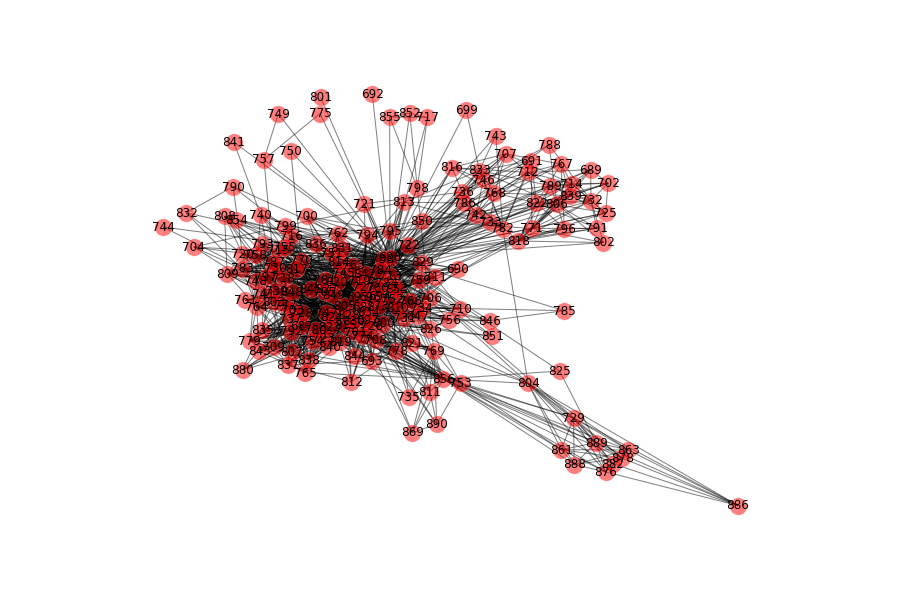

In [23]:
from IPython.html.widgets import interact
import graph_helpers
from imp import reload
reload(graph_helpers)

@interact
def plot(cl = ('5', '6', '7', '8', '10', '20', '30', '27', '215', '42', '1150'), 
         degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (clusters == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % graph_helpers.get_deg_sub(facebook2, clusters == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, clusters == cl, int(degree), layout=layout, graph=g)

In [24]:
n = 46401

print((clusters[n]), (clusters == clusters[n]).sum())
print((df["0"] == n).sum())
print((df["1"] == n).sum())
df[(df["1"] == n) | (df["0"] == n)]

IndexError: index 46401 is out of bounds for axis 0 with size 4039

In [ ]:
df.head()

In [ ]:
from gmet import group_vertex_degree, group_edge_degree

%time all_degs = [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)]

print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=100)
plt.yscale("log")

### Optimisation à faire
Il faudrait optimiser le calcul des deux "degrés" en le faisant en masse par un big produit matriciel

### Compléments à faire
- implémenter d'autres métriques (cf littérature) comme le RatioCut = sigma cuts / taille et Ncut = sigma cuts / vol
- remettre en non normalisé!
- diminuer le k du k-means

In [ ]:
from gmet import group_vertex_degree, group_edge_degree

%time metrics = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

metrics["vratio"] = metrics.vdeg / metrics.sz
metrics["eratio"] = metrics.edeg / metrics.sz

metrics.describe()

In [ ]:
metrics[metrics.vratio < 0.5].describe()

In [ ]:
metrics[metrics.vratio < 0.5][metrics.vdeg < 10].describe()

In [ ]:
metrics[metrics.eratio < 0.5].describe()

In [ ]:
def eratios(df):
    return np.array([len(metrics[metrics.eratio < i])/len(metrics) for i in range(10)])

def perf(df):
    return (eratios(df)/10).sum()

er = eratios(metrics)

print (perf(metrics))

plt.plot(er)

In [ ]:
from imp import reload
import gmet
reload(gmet)

matrics["ratio_cut"] = gmet.ratio_cut()